### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [2]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [3]:
# Cargamos los datos de las obras de Borges, utilizada en el TP anterior
file = '/content/boc.csv'
df = pd.read_csv(file,sep='/n', header=None)
# Dataset is now stored in a Pandas Dataframe

df.head()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,0
0,"Quiero dejar escrita una confesión, que a un t..."
1,"íntima y general, ya que las cosas que. le ocu..."
2,hombre les ocurren a todos. Estoy hablando de ...
3,"remoto y perdido, los días de mi santo, los má..."
4,Yo recibía los regalos y yo pensaba que no era...


In [4]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 36332


In [5]:
# Achicamos la cantidad de documentos porque luego nos quedamos sin memoria RAM para la ejecución
df = df[:5000]
df.shape[0]

5000

In [6]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_teokenize de nltk
from keras.preprocessing.sequence import pad_sequences # se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 4

### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [7]:
# Vistazo a las primeras filas
df.loc[:15,0]

0     Quiero dejar escrita una confesión, que a un t...
1     íntima y general, ya que las cosas que. le ocu...
2     hombre les ocurren a todos. Estoy hablando de ...
3     remoto y perdido, los días de mi santo, los má...
4     Yo recibía los regalos y yo pensaba que no era...
5     un chico y que no había hecho nada, absolutame...
6     para merecerlos. Pof supuesto, nunca lo dije; ...
7     tímida. Desde entonces me has dado tantas cosa...
8     tantos los años y los recuerdos. Padre, Norah,...
9     tu memoria y en ella la memoria de los mayores...
10    patios, los esclavos, el aguace'; c\ la carga ...
11    del Perú y el oprobio de Rosas—, tu prisión va...
12    cuando tantos hombres callábamos, las mañanas ...
13    del Molino, de Ginebra y de Austin, las compar...
14    y sombras, tu fresca ancianidad, tu amor a Dic...
15                y a Eca de Queiroz, Madre, vos misma.
Name: 0, dtype: object

In [8]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

'Quiero dejar escrita una confesión, que a un tiempo será íntima y general, ya que las cosas que. le ocurren a un hombre les ocurren a todos. Estoy hablando de algo ya remoto y perdido, los días de mi santo, los más antiguos. Yo recibía los regalos y yo pensaba que no era más que un chico y que no había hecho nada, absolutamente .nada, para merecerlos. Pof supuesto, nunca lo dije; la niñez es tímida. Desde entonces me has dado tantas cosas y son tantos los años y los recuerdos. Padre, Norah, los abuelos, tu memoria y en ella la memoria de los mayores —los patios, los esclavos, el aguace\'; c\\ la carga de los húsares del Perú y el oprobio de Rosas—, tu prisión valerosa, cuando tantos hombres callábamos, las mañanas del Paso del Molino, de Ginebra y de Austin, las compartidas claridades y sombras, tu fresca ancianidad, tu amor a Dickens y a Eca de Queiroz, Madre, vos misma. Aquí estamos hablando los dos, et tout le reste csi littérature, como escribió, con excelente literatura, feríame.

In [9]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['quiero',
 'dejar',
 'escrita',
 'una',
 'confesión',
 'que',
 'a',
 'un',
 'tiempo',
 'será',
 'íntima',
 'y',
 'general',
 'ya',
 'que',
 'las',
 'cosas',
 'que',
 'le',
 'ocurren']

In [10]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 40977


In [11]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [12]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['quiero', 'dejar', 'escrita', 'una'],
 ['dejar', 'escrita', 'una', 'confesión'],
 ['escrita', 'una', 'confesión', 'que'],
 ['una', 'confesión', 'que', 'a'],
 ['confesión', 'que', 'a', 'un'],
 ['que', 'a', 'un', 'tiempo'],
 ['a', 'un', 'tiempo', 'será'],
 ['un', 'tiempo', 'será', 'íntima'],
 ['tiempo', 'será', 'íntima', 'y'],
 ['será', 'íntima', 'y', 'general'],
 ['íntima', 'y', 'general', 'ya'],
 ['y', 'general', 'ya', 'que'],
 ['general', 'ya', 'que', 'las'],
 ['ya', 'que', 'las', 'cosas'],
 ['que', 'las', 'cosas', 'que'],
 ['las', 'cosas', 'que', 'le'],
 ['cosas', 'que', 'le', 'ocurren'],
 ['que', 'le', 'ocurren', 'a'],
 ['le', 'ocurren', 'a', 'un'],
 ['ocurren', 'a', 'un', 'hombre']]

In [13]:
# Proceso de tokenizacion
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[316, 919, 620, 13],
 [919, 620, 13, 1793],
 [620, 13, 1793, 4],
 [13, 1793, 4, 8],
 [1793, 4, 8, 11],
 [4, 8, 11, 44],
 [8, 11, 44, 261],
 [11, 44, 261, 920],
 [44, 261, 920, 5],
 [261, 920, 5, 194],
 [920, 5, 194, 33],
 [5, 194, 33, 4],
 [194, 33, 4, 10],
 [33, 4, 10, 105],
 [4, 10, 105, 4],
 [10, 105, 4, 30],
 [105, 4, 30, 1794],
 [4, 30, 1794, 8],
 [30, 1794, 8, 11],
 [1794, 8, 11, 66]]

In [14]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 40973


### 3 - Input y target

In [15]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(40973, 3)
(40973,)


In [16]:
# Palabras del vocabulario
tok.index_word

{1: 'de',
 2: 'la',
 3: 'el',
 4: 'que',
 5: 'y',
 6: 'en',
 7: 'los',
 8: 'a',
 9: 'del',
 10: 'las',
 11: 'un',
 12: 'es',
 13: 'una',
 14: 'no',
 15: 'su',
 16: 'se',
 17: 'con',
 18: 'lo',
 19: 'por',
 20: 'como',
 21: 'o',
 22: 'para',
 23: 'al',
 24: 'más',
 25: 'esa',
 26: 'mi',
 27: 'me',
 28: 'carriego',
 29: 'pero',
 30: 'le',
 31: 'sus',
 32: 'sin',
 33: 'ya',
 34: 'yo',
 35: 'ese',
 36: 'era',
 37: 'luis',
 38: 'ha',
 39: 'si',
 40: 'jorge',
 41: 'completas',
 42: 'son',
 43: 'he',
 44: 'tiempo',
 45: 'buenos',
 46: 'también',
 47: 'aires',
 48: 'vida',
 49: 'tu',
 50: 'calle',
 51: 'dos',
 52: 'borges—obras',
 53: 'está',
 54: 'ser',
 55: 'nos',
 56: 'sobre',
 57: 'muerte',
 58: 'él',
 59: 'cuando',
 60: 'esta',
 61: 'noche',
 62: 'tan',
 63: 'siempre',
 64: 'tango',
 65: 'evaristo',
 66: 'hombre',
 67: 'fierro',
 68: 'fue',
 69: 'barrio',
 70: 'hombres',
 71: 'este',
 72: 'porque',
 73: 'entre',
 74: 'vez',
 75: 'todo',
 76: 'hay',
 77: 'después',
 78: 'ni',
 79: 'otra',


In [17]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

9891

In [18]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(40973, 9891)

### 4 - Entrenar el modelo

In [19]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [20]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

9891

In [21]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128)) # La última capa LSTM no lleva return_sequences
model.add(Dense(64, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 5)              49460     
                                                                 
 lstm (LSTM)                 (None, 3, 128)            68608     
                                                                 
 dropout (Dropout)           (None, 3, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 9891)              642915    
                                                                 
Total params: 900,823
Trainable params: 900,823
Non-trai

In [22]:
y_data.shape

(40973, 9891)

In [23]:
hist = model.fit(x_data, y_data, epochs=50, validation_split=0.2)

Epoch 1/50
1025/1025 [==============================] - 20s 12ms/step - loss: 7.4475 - accuracy: 0.0622 - val_loss: 7.5470 - val_accuracy: 0.0589
Epoch 2/50
1025/1025 [==============================] - 10s 10ms/step - loss: 6.8959 - accuracy: 0.0628 - val_loss: 7.7011 - val_accuracy: 0.0589
Epoch 3/50
1025/1025 [==============================] - 10s 9ms/step - loss: 6.7360 - accuracy: 0.0629 - val_loss: 7.9185 - val_accuracy: 0.0598
Epoch 4/50
1025/1025 [==============================] - 10s 9ms/step - loss: 6.4708 - accuracy: 0.0740 - val_loss: 8.0300 - val_accuracy: 0.0639
Epoch 5/50
1025/1025 [==============================] - 10s 9ms/step - loss: 6.2244 - accuracy: 0.0794 - val_loss: 8.3562 - val_accuracy: 0.0671
Epoch 6/50
1025/1025 [==============================] - 10s 10ms/step - loss: 6.0274 - accuracy: 0.0825 - val_loss: 8.4510 - val_accuracy: 0.0672
Epoch 7/50
1025/1025 [==============================] - 9s 9ms/step - loss: 5.8681 - accuracy: 0.0855 - val_loss: 8.7728 - val_

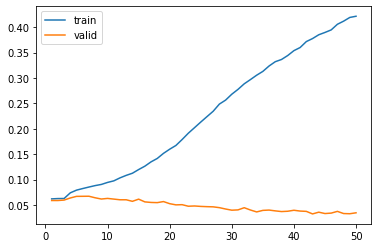

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Predicción de próxima palabra

In [25]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [26]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

     |████████████████████████████████| 5.6 MB 5.0 MB/s 
     |████████████████████████████████| 84 kB 4.0 MB/s 
     |████████████████████████████████| 84 kB 4.0 MB/s 
     |████████████████████████████████| 54 kB 3.8 MB/s 
     |████████████████████████████████| 2.3 MB 46.8 MB/s 
     |████████████████████████████████| 212 kB 59.8 MB/s 
     |████████████████████████████████| 275 kB 61.1 MB/s 
     |████████████████████████████████| 54 kB 3.7 MB/s 
     |████████████████████████████████| 141 kB 76.9 MB/s 
     |████████████████████████████████| 57 kB 6.2 MB/s 
     |████████████████████████████████| 63 kB 2.5 MB/s 
     |████████████████████████████████| 80 kB 7.7 MB/s 
     |████████████████████████████████| 68 kB 8.1 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 856 kB 55.3 MB/s 
     |████████████████████████████████| 62 kB 1.1 MB/s 
     |████████████████████████████████| 4.1 MB 52.2 MB/s 


In [27]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `layout` parameter is deprecated, and it has no effect
  warnings.warn(value)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://28860.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


Keyboard interruption in main thread... closing server.


(<gradio.routes.App at 0x7f2077b9a410>,
 'http://127.0.0.1:7860/',
 'https://28860.gradio.app')

### 6 - Generación de secuencias nuevas

In [28]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [33]:
input_text='hola Borges varas'

generate_seq(model, tok, input_text, max_length=3, n_words=2)

'hola Borges varas y buena'

### 7 - Conclusiones
El modelo entrenado tuvo un muy mail desempeño en el entrenamiento además de overfitting. Cuestiones que podrían mejorarse:
- Agregar un pre-procesado para eliminar los símbolos del idioma Español.
- Lematizar el texto 
- Probar con distintos hiperparámetros del modelo
- Utilizar una matriz de Embeddings ya pre-entrenada

